In [50]:
import numpy as np
import pandas as pd
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup, DistilBertTokenizer, DistilBertModel
import torch
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import DistilBertForSequenceClassification
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from collections import Counter
from wordcloud import WordCloud

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# EDA

In [2]:
yes_no = pd.read_csv('yes_no_sample.csv', 
                    header=None, names=['text', 'label'])

In [3]:
yes_no.head()

,text,label
0,а хорошо я поняла прийти однозначно я не смогу...,disagree
1,вот я поеду в город каменки там попробую обнов...,agree
2,нет не готов я,disagree
3,нет без нас никакой вести не смогу,disagree
4,больше нет никакой,disagree


In [4]:
yes_no['label'].value_counts()

disagree    585
agree       532
confused    320
Name: label, dtype: int64

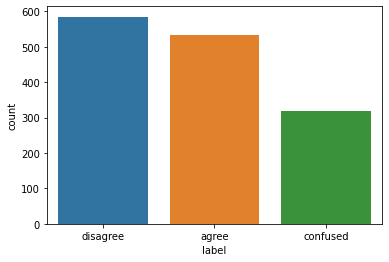

In [5]:
label_names = ['disagree', 'confused', 'agree']

ax = sns.countplot(yes_no['label'])

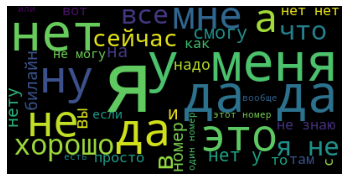

In [7]:
text = ' '.join(yes_no['text'])
 
cloud = WordCloud(max_words=40).generate(text)
plt.imshow(cloud)
plt.axis('off');

In [8]:
yes_no['label'].replace('disagree', 0, inplace=True)
yes_no['label'].replace('confused', 1, inplace=True)
yes_no['label'].replace('agree', 2, inplace=True)

# TF-IDF

In [10]:
df_train, df_test = train_test_split(yes_no, test_size=0.3, random_state=RANDOM_SEED, shuffle=True, stratify=yes_no['label'])

In [11]:
text_transformer = TfidfVectorizer(ngram_range=(2, 4), lowercase=True, max_features=150000)

In [12]:
X_train_text = text_transformer.fit_transform(df_train['text'])
X_test_text = text_transformer.transform(df_test['text'])

In [13]:
X_train_text.shape, X_test_text.shape

((1005, 8515), (432, 8515))

# LogReg

In [14]:
lr_model_base = LogisticRegression()

In [15]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [16]:
cv_results = cross_val_score(lr_model_base, X_train_text, df_train['label'], cv=skf, scoring='f1_micro')

In [17]:
cv_results.mean()

0.6258706467661691

In [19]:
lr_model_base.fit(X_train_text, df_train['label'])

LogisticRegression()

In [20]:
lr_base_preds = lr_model_base.predict(X_test_text)

In [27]:
print(classification_report(df_test['label'], lr_base_preds))

              precision    recall  f1-score   support

           0       0.62      0.94      0.75       176
           1       0.85      0.41      0.55        96
           2       0.83      0.62      0.71       160

    accuracy                           0.70       432
   macro avg       0.77      0.66      0.67       432
weighted avg       0.75      0.70      0.69       432



In [30]:
lr_grid = {
    "C": np.logspace(-3, 3, 7), 
    "penalty": ["l1", "l2"]
}

lr_model_grid = LogisticRegression()
lr_cv = GridSearchCV(lr_model_grid, lr_grid, cv=5)
lr_cv.fit(X_train_text, df_train['label'])

print("best parameters", lr_cv.best_params_)
print("accuracy :", lr_cv.best_score_)

best parameters {'C': 1000.0, 'penalty': 'l2'}
accuracy : 0.718407960199005


In [33]:
lr_model_grid = LogisticRegression(C=1000, penalty='l2')
lr_model_grid.fit(X_train_text, df_train['label'])
lr_grid_preds = lr_model_grid.predict(X_test_text)

In [35]:
print(classification_report(df_test['label'], lr_grid_preds))

              precision    recall  f1-score   support

           0       0.88      0.76      0.82       176
           1       0.82      0.64      0.72        96
           2       0.71      0.91      0.80       160

    accuracy                           0.79       432
   macro avg       0.80      0.77      0.78       432
weighted avg       0.80      0.79      0.79       432



Видно, что при регуляризации метрики стали выше

# MultinomialNB

In [38]:
mnb_model = MultinomialNB()

In [39]:
cv_results = cross_val_score(mnb_model, X_train_text, df_train['label'], cv=skf, scoring='f1_micro')

In [40]:
cv_results.mean()

0.618905472636816

In [41]:
mnb_model.fit(X_train_text, df_train['label'])

MultinomialNB()

In [42]:
mnb_base_preds = mnb_model.predict(X_test_text)

In [43]:
print(classification_report(df_test['label'], mnb_base_preds))

              precision    recall  f1-score   support

           0       0.60      0.94      0.73       176
           1       0.87      0.27      0.41        96
           2       0.81      0.63      0.71       160

    accuracy                           0.68       432
   macro avg       0.76      0.62      0.62       432
weighted avg       0.74      0.68      0.65       432



In [47]:
parameters = {  
'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001)  
}

In [48]:
mnb_model_grid = MultinomialNB()
mnb_cv = GridSearchCV(mnb_model_grid, parameters, cv=5)
mnb_cv.fit(X_train_text, df_train['label'])

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 1e-05)})

In [49]:
print("best parameters", mnb_cv.best_params_)
print("accuracy :", mnb_cv.best_score_)

best parameters {'alpha': 1e-05}
accuracy : 0.7203980099502488


# SVM

In [51]:
# Параметры тоже подобраны с помощью GridSearch
svm_model = SVC(C=1.0, kernel='linear', degree=3, gamma='auto')

In [52]:
cv_results = cross_val_score(svm_model, X_train_text, df_train['label'], cv=skf, scoring='f1_micro')

In [53]:
cv_results.mean()

0.690547263681592

# BERT

In [54]:
PRE_TRAINED_MODEL_NAME = 'DeepPavlov/distilrubert-tiny-cased-conversational'

In [55]:
tokenizer = DistilBertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [56]:
MAX_LEN = 512

In [57]:
class Yes_No(Dataset):
    
    def __init__(self, text, label, tokenizer, max_len):
        self.text = text
        self.label = label
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, item):
        text = str(self.text[item])
        label = self.label[item]
        
        encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True)
        
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [58]:
df_train, df_test = train_test_split(yes_no, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [59]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = Yes_No(
                text=yes_no['text'].to_numpy(),
                label=yes_no['label'].to_numpy(),
                tokenizer=tokenizer,
                max_len=max_len)
    
    return DataLoader(
    ds, 
    batch_size=batch_size
    )

In [60]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [61]:
class Yes_No_Classifier(nn.Module):
    
    def __init__(self, n_classes):
        super(Yes_No_Classifier, self).__init__()
        self.bert = DistilBertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    
    def forward(self, input_ids, attention_mask):
        pooled_output = torch.mean(self.bert(
                                    input_ids=input_ids,
                                    attention_mask=attention_mask)['last_hidden_state'], dim=1)
        
        output = self.drop(pooled_output)
        return self.out(output)

In [62]:
model = Yes_No_Classifier(len(label_names))
model = model.to(device)

Some weights of the model checkpoint at DeepPavlov/distilrubert-tiny-cased-conversational were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [63]:
EPOCHS = 3

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) + EPOCHS

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

loss_fn = nn.CrossEntropyLoss().to(device)

In [77]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    
    losses = []
    correct_predictions = 0
    
    for d in data_loader:
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        labels = d['labels'].to(device)
        outputs = model(input_ids=input_ids,
                        attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)
        
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
    return correct_predictions.double() / n_examples, np.mean(losses)
#     return np.mean(losses)

In [78]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            labels = d['labels'].to(device)
            outputs = model(input_ids=input_ids,
                        attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, labels)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())
    
    return correct_predictions.double() / n_examples, np.mean(losses)
#     return np.mean(losses)      

In [81]:
%%time

history = defaultdict(list)
best_accuracy = 0
best_loss = 10

for epoch in range(EPOCHS):
    
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    
    train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))
#     train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))
    print(f'Train loss {train_loss}, accuracy {train_acc}')
#     print(f'Train loss {train_loss}')
    val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, device, len(df_test))
#     val_loss = eval_model(model, val_data_loader, loss_fn, device, len(df_test))
#     print(f'Val loss {val_loss}')
    print(f'Val loss {val_loss}, accuracy {val_acc}')
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    if val_acc > best_accuracy and val_loss < best_loss:
#     if val_loss[0][1] < best_loss:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc
        best_loss = val_loss

Epoch 1/3
----------
Train loss 0.2194098033838802, accuracy 1.0224284609435421
Val loss 0.2090663370779819, accuracy 18.40277777777778
Epoch 2/3
----------
Train loss 0.22406525353176726, accuracy 1.0224284609435421
Val loss 0.2090663370779819, accuracy 18.40277777777778
Epoch 3/3
----------
Train loss 0.22642909553315904, accuracy 1.0185614849187936
Val loss 0.2090663370779819, accuracy 18.40277777777778
Wall time: 54min


In [82]:
history

defaultdict(list,
            {'train_acc': [tensor(1.0224, dtype=torch.float64),
              tensor(1.0224, dtype=torch.float64),
              tensor(1.0186, dtype=torch.float64)],
             'train_loss': [0.2194098033838802,
              0.22406525353176726,
              0.22642909553315904],
             'val_acc': [tensor(18.4028, dtype=torch.float64),
              tensor(18.4028, dtype=torch.float64),
              tensor(18.4028, dtype=torch.float64)],
             'val_loss': [0.2090663370779819,
              0.2090663370779819,
              0.2090663370779819]})

## best model

In [83]:
model = Yes_No_Classifier(len(label_names))
model.load_state_dict(torch.load('best_model_state.bin'))
model = model.to(device)

Some weights of the model checkpoint at DeepPavlov/distilrubert-tiny-cased-conversational were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [84]:
test_acc, _ = eval_model(model, test_data_loader, loss_fn, device, len(df_test))

In [85]:
def get_predictions(model, data_loader):
    model = model.eval()
    
    yes_no_texts = []
    predictions = []
    prediction_probs = []
    real_labels = []
    
    with torch.no_grad():
        for d in data_loader:
            
            texts = d['text']
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            labels = d['labels'].to(device)
            
            outputs = model(input_ids=input_ids,
                           attention_mask=attention_mask
                           )
            _, preds = torch.max(outputs, dim=1)
            
            probs = F.softmax(outputs, dim=1)
            
            yes_no_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_labels.extend(labels)
            
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_labels = torch.stack(real_labels).cpu()
    
    return yes_no_texts, predictions, prediction_probs, real_labels         

In [86]:
y_yes_no_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

In [87]:
print(classification_report(y_test, y_pred, target_names=label_names))

              precision    recall  f1-score   support

    disagree       0.93      0.93      0.93       585
    confused       0.88      0.92      0.90       320
       agree       0.94      0.91      0.93       532

    accuracy                           0.92      1437
   macro avg       0.92      0.92      0.92      1437
weighted avg       0.92      0.92      0.92      1437



In [88]:
test_text = 'не хочу'

In [89]:
encoded_text = tokenizer.encode_plus(test_text,
                                    max_length=MAX_LEN,
                                    add_special_tokens=True,
                                    return_token_type_ids=False,
                                    pad_to_max_length=True,
                                    return_attention_mask=True,
                                    return_tensors='pt')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [90]:
input_ids = encoded_text['input_ids'].to(device)
attention_mask = encoded_text['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Text: {test_text}')
print(f'Label: {label_names[prediction]}')

Text: не хочу
Label: disagree
